# Summarize genes expression from CREST Hepatocytes experimentas

###### Questions: Felipe Albrecht (felipe.albrecht@gmail.com) August 17, 2017

#### All communication to DeepBlue Data Server is made through XML-RPC protocol.
#### We are going to use the *xmlrpclib* package in  Python 2.

In [1]:
import xmlrpclib

#### We connect to the DeepBlue URL and create a object that will work as a proxy between our code and the server.

In [2]:
url = "http://deepblue.mpi-inf.mpg.de/xmlrpc"
deepblue = xmlrpclib.Server(url, allow_none=True)

##### We need a user key to access DeepBlue. We are going to use the public and anonymous anonymous key that DeepBlue offer. Is it strongly recommended to register at [Register Page](http://deepblue.mpi-inf.mpg.de/register.php).

In [3]:
USER_KEY = "anonymous_key"

#### We use the command [echo](http://deepblue.mpi-inf.mpg.de/api.php#api-echo) to check your connection with DeepBlue

In [4]:
print deepblue.echo(USER_KEY)

['okay', 'DeepBlue (1.17.7) says hi to anonymous']


#### We use the command [list_experiments](http://deepblue.mpi-inf.mpg.de/api.php#api-list_experiments) to list all mRNA experiments from Hepatocytes and from the CREST project.

In [5]:
status, experiments = deepblue.list_experiments("GRCh38", "signal", 
                                                "mRNA", "hepatocyte", 
                                                None, None, "CREST", 
                                                USER_KEY)

In [6]:
experiments

[['e107350', 'HPC6_hg38_RNAseq.ucsc.bedgraph'],
 ['e107347', 'HPC35_hg38_RNAseq.ucsc.bedgraph'],
 ['e107281', 'HPC25_hg38_RNAseq.ucsc.bedgraph'],
 ['e107285', 'HPC28_hg38_RNAseq.ucsc.bedgraph'],
 ['e107283', 'HPC20_hg38_RNAseq.ucsc.bedgraph'],
 ['e107279', 'HPC8_hg38_RNAseq.ucsc.bedgraph'],
 ['e107278', 'HPC17_hg38_RNAseq.ucsc.bedgraph'],
 ['e107269', 'HPC27_hg38_RNAseq.ucsc.bedgraph']]

#### The list_experiments return a list of IDs and names. We use the command [extract_names](http://deepblue.mpi-inf.mpg.de/api.php#api-extract_names) to obtain the experiments names.

In [7]:
status, experiment_names = deepblue.extract_names(experiments)

In [8]:
experiment_names

['HPC6_hg38_RNAseq.ucsc.bedgraph',
 'HPC35_hg38_RNAseq.ucsc.bedgraph',
 'HPC25_hg38_RNAseq.ucsc.bedgraph',
 'HPC28_hg38_RNAseq.ucsc.bedgraph',
 'HPC20_hg38_RNAseq.ucsc.bedgraph',
 'HPC8_hg38_RNAseq.ucsc.bedgraph',
 'HPC17_hg38_RNAseq.ucsc.bedgraph',
 'HPC27_hg38_RNAseq.ucsc.bedgraph']

#### We select manually some genes. A list of Genes can be found in the [Web Interface](http://deepblue.mpi-inf.mpg.de/dashboard.php#ajax/deepblue_view_genes.php)

In [9]:
genes = ["ADH1A", "ADH1C", "ADH4", "ADH5", "ADH6", "ADH7", 
         "GSTA1", "GSTA2", "GSTA3", "GSTA4"]

#### The list_experiments return a list of IDs and names. We use the command [select_genes](http://deepblue.mpi-inf.mpg.de/api.php#api-select_genes) select the genes and return a query ID.

In [10]:
(status, q_genes) = deepblue.select_genes(genes, None, 
                                          "gencode v23", None, None, None, USER_KEY)

In [11]:
q_genes

'q987661'

#### We obtain the genes from the server. We do it to obtain the genes in "genomic order". The  [get_regions](http://deepblue.mpi-inf.mpg.de/api.php#api-get_regions) command is usually to obtain the epigenomic data, but in this case we use to obtain the gene names (using the meta-field @GENE_NAME). This data will be used further. 

In [12]:
(status, request_id) = deepblue.get_regions(q_genes, 
                                            "@GENE_NAME(gencode v22)", 
                                            USER_KEY)

#### The following function is used to wait DeepBlue processing and download the data.

In [17]:
import time
def download_data(request_id):
 (status, info) = deepblue.info(request_id, USER_KEY)
 request_status = info[0]["state"]
 while request_status != "done" and request_status != "failed":
   print request_status 
   time.sleep(1)
   (status, info) = deepblue.info(request_id, USER_KEY)
   request_status = info[0]["state"]
 (status, regions) = deepblue.get_request_data(request_id, USER_KEY)
 return regions

In [18]:
genes_ordered = download_data(request_id)

#### We verify the output.

In [19]:
print genes_ordered

ADH5
ADH4
ADH6
ADH1A
ADH1C
ADH7
GSTA2
GSTA1
GSTA3
GSTA4


## Building the score matrix

#### We have to create a dictionary, with the experiment names as key and the column name as value. For this case, we use the column named "VALUE", that is the default value column in the DeepBlue signal data.

In [20]:
experiments_columns = {}
for experiment_name in experiment_names:
    experiments_columns[experiment_name] = "VALUE"


In [21]:
experiments_columns

{'HPC17_hg38_RNAseq.ucsc.bedgraph': 'VALUE',
 'HPC20_hg38_RNAseq.ucsc.bedgraph': 'VALUE',
 'HPC25_hg38_RNAseq.ucsc.bedgraph': 'VALUE',
 'HPC27_hg38_RNAseq.ucsc.bedgraph': 'VALUE',
 'HPC28_hg38_RNAseq.ucsc.bedgraph': 'VALUE',
 'HPC35_hg38_RNAseq.ucsc.bedgraph': 'VALUE',
 'HPC6_hg38_RNAseq.ucsc.bedgraph': 'VALUE',
 'HPC8_hg38_RNAseq.ucsc.bedgraph': 'VALUE'}

#### We build the [score_matrix](http://deepblue.mpi-inf.mpg.de/api.php#api-score_matrix) using the defined *experiments_columns* , where we calculate the *mean* value by the regions defined in the *q_genes*.

In [22]:
status, score_matrix_request = deepblue.score_matrix(experiments_columns, 
                                                     "mean", 
                                                     q_genes, 
                                                     USER_KEY)

#### We download the data and print it.

In [23]:
score_matrix_genes = download_data(score_matrix_request)

running


In [33]:
print score_matrix_genes

CHROMOSOME	START	END	HPC17_hg38_RNAseq.ucsc.bedgraph	HPC20_hg38_RNAseq.ucsc.bedgraph	HPC25_hg38_RNAseq.ucsc.bedgraph	HPC27_hg38_RNAseq.ucsc.bedgraph	HPC28_hg38_RNAseq.ucsc.bedgraph	HPC35_hg38_RNAseq.ucsc.bedgraph	HPC6_hg38_RNAseq.ucsc.bedgraph	HPC8_hg38_RNAseq.ucsc.bedgraph
chr4	99070978	99088801	45.6722	40.5456	31.3338	24.8331	49.0315	49.0315	37.8134	50.5771
chr4	99123657	99157792	631.561	552.589	492.069	319.377	716.801	716.801	308.469	472.811
chr4	99202638	99219537	117.781	126.636	165.364	112.304	103.459	103.459	85.5146	125.97
chr4	99276367	99291028	450.016	438.969	285.043	254.708	378.242	378.242	126.98	348.767
chr4	99336492	99353027	416.424	544.699	322.99	253.446	257.816	257.816	159.762	382.319
chr4	99412261	99435737	0.152611	0.205124	0.285826	0.416667	-0.0880021	-0.0880021		0.149581
chr6	52750089	52763569	152.439	16.0667	94.077	102.796	262.549	262.549	74.0055	50.084
chr6	52791664	52803910	194.003	196.749	326.886	181.822	251.718	251.718	199.522	244.604
chr6	52847910	52909685	1.21667

## Importing the data into numpy

In [34]:
import numpy as np

In [35]:
from io import BytesIO

#### We import the data into a numpy data structure. For this, we use the command genfromtxt, using tabs as delimiters, skipping the first row (the header), and using columns from the 3rd position. 

In [36]:
experiments_count = len(experiment_names)
print experiments_count

8


In [37]:
data = np.genfromtxt(BytesIO(score_matrix_genes), delimiter="\t", 
                     skip_header=1, 
                     usecols = range(3,experiments_count+3))

In [38]:
print data

[[  4.56722000e+01   4.05456000e+01   3.13338000e+01   2.48331000e+01
    4.90315000e+01   4.90315000e+01   3.78134000e+01   5.05771000e+01]
 [  6.31561000e+02   5.52589000e+02   4.92069000e+02   3.19377000e+02
    7.16801000e+02   7.16801000e+02   3.08469000e+02   4.72811000e+02]
 [  1.17781000e+02   1.26636000e+02   1.65364000e+02   1.12304000e+02
    1.03459000e+02   1.03459000e+02   8.55146000e+01   1.25970000e+02]
 [  4.50016000e+02   4.38969000e+02   2.85043000e+02   2.54708000e+02
    3.78242000e+02   3.78242000e+02   1.26980000e+02   3.48767000e+02]
 [  4.16424000e+02   5.44699000e+02   3.22990000e+02   2.53446000e+02
    2.57816000e+02   2.57816000e+02   1.59762000e+02   3.82319000e+02]
 [  1.52611000e-01   2.05124000e-01   2.85826000e-01   4.16667000e-01
   -8.80021000e-02  -8.80021000e-02              nan   1.49581000e-01]
 [  1.52439000e+02   1.60667000e+01   9.40770000e+01   1.02796000e+02
    2.62549000e+02   2.62549000e+02   7.40055000e+01   5.00840000e+01]
 [  1.9400300

## Plotting the data

#### We use the matplotlib for generating a boxplot of the gene expressions.

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize=(14, 10))
plt.xlabel('Gene')
plt.ylabel('Expression level')

# Create an axes instance
ax = fig.add_subplot(111)

#### We transpose the data because we want to plot the gene levels by gene.

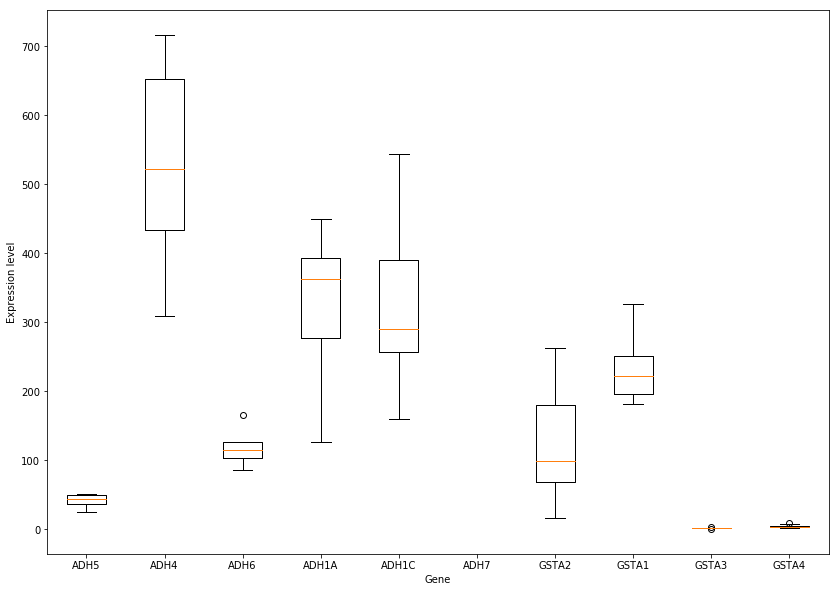

In [40]:
# Create the boxplot
bp = ax.boxplot(data.transpose(), 
                labels=genes_ordered.split("\n"))

plt.show()